In [1]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
import torch

from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit,train_epoch
import numpy as np
cuda = torch.cuda.is_available()

In [3]:
from datasets import TripletSampling, BatchPairSampling
from networks import EmbeddingNet, TripletNet, SiameseNet
from losses import TripletLoss, HardHardNegativesBatchLoss, HardEasyNegativesBatchLoss, SCTLossCosine

In [50]:
def extract_embeddings(dataset, labels, model):
    with torch.no_grad():
        model.eval()
        embeddings = []

        for data in dataset:

            embeddings.append( 
                np.array( 
                    model.get_embedding(data).detach().numpy() ) )

    return np.array(embeddings), labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    targets = np.array(targets)
    colors = ['r', 'b']
    shapes = ['*', '^']
    for cls in set(targets):
        mask = targets == cls
        cls_emb = embeddings[mask]
        plt.scatter(cls_emb[:,0], cls_emb[:,1], alpha=0.5, marker = shapes[cls],c = colors[cls])

    plt.legend(set(targets))
    
def dissim_matrix(data, name):
    """helper for mds visualization"""
    from scipy.spatial import distance
    return distance.cdist(data, data, metric= name)

def smaples_for_plotting(percentage, labels, data):
    """ reduce # of data, for plotting"""
    percentage = 0.5
    labels = np.array(labels)
    label_to_indices = {label: np.where(labels == label)[0]
                             for label in labels}


    true_num = int( len(label_to_indices[1]) * percentage )
    false_num = int( len(label_to_indices[0]) * percentage )

    positive_index = np.random.choice( label_to_indices[1], true_num)
    negative_index= np.random.choice(label_to_indices[0], false_num)

    index = np.concatenate( [positive_index, negative_index], axis = 0)

    return data[index], labels[index]


tsne = TSNE(n_components=2, perplexity = 5, learning_rate='auto',init='random')
mds = sklearn.manifold.MDS(n_components=2,metric= True, 
                                  n_init=4, 
                                  max_iter=100,
                                  verbose=0, eps=0.001, n_jobs=-1, random_state= 10, dissimilarity='precomputed')

## Friedman

In [5]:
friedman = pd.read_csv('./data/Friedman_data.csv')
drop_columns = ['y']
friedman = friedman.drop(drop_columns, axis = 1)

In [6]:
friedman_shuffled = friedman.sample(frac=1).reset_index(drop=True)
from sklearn.mixture import GaussianMixture

# use Gs to do clustering
labels = GaussianMixture(n_components=2, random_state=0).fit_predict(friedman_shuffled)

In [7]:
train_X_fried, test_X_fried,train_label_fried, test_label_fried = train_test_split(
    friedman_shuffled, labels, test_size=0.33, random_state=42)

train_X_fried_tensor = torch.tensor(train_X_fried.values )
test_X_fried_tensor = torch.tensor(test_X_fried.values )

In [13]:
distance = None
margin = 1
loss_fn = HardEasyNegativesBatchLoss( margin = margin, distance = distance)
lr = 1e-3

hidden_size = 20
embedding_size = 5
input_size = train_X_fried_tensor.shape[1]

net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20

datasampler = BatchPairSampling( dataset = train_X_fried_tensor , labels= train_label_fried)
batch_size = 8 
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 20

In [14]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/670 (0%)]	Loss: 0.997855
Train: [160/670 (24%)]	Loss: 0.994438
Train: [320/670 (48%)]	Loss: 0.979599
Train: [480/670 (71%)]	Loss: 0.870876
Train: [640/670 (95%)]	Loss: 0.349833
Epoch: 1/20. Train set: Average loss: 0.7725
Train: [0/670 (0%)]	Loss: 0.779283
Train: [160/670 (24%)]	Loss: 0.454152
Train: [320/670 (48%)]	Loss: 0.277122
Train: [480/670 (71%)]	Loss: 0.193522
Train: [640/670 (95%)]	Loss: 0.160535
Epoch: 2/20. Train set: Average loss: 0.2677
Train: [0/670 (0%)]	Loss: 0.000000
Train: [160/670 (24%)]	Loss: 0.069336
Train: [320/670 (48%)]	Loss: 0.052197
Train: [480/670 (71%)]	Loss: 0.048939
Train: [640/670 (95%)]	Loss: 0.105002
Epoch: 3/20. Train set: Average loss: 0.0656
Train: [0/670 (0%)]	Loss: 0.000000
Train: [160/670 (24%)]	Loss: 0.034144
Train: [320/670 (48%)]	Loss: 0.143161
Train: [480/670 (71%)]	Loss: 0.135024
Train: [640/670 (95%)]	Loss: 0.071704
Epoch: 4/20. Train set: Average loss: 0.0914
Train: [0/670 (0%)]	Loss: 0.000000
Train: [160/670 (24%)]	Loss: 0.066272

#### Visualize train

In [15]:
train_embs,train_labels = extract_embeddings(train_X_fried_tensor , train_label_fried, model)

In [16]:
name = 'euclidean'
train_dis = dissim_matrix(train_embs, name)

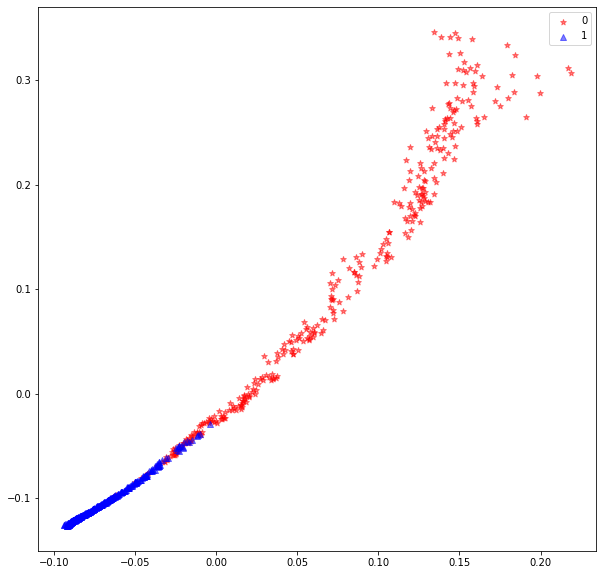

In [17]:
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, train_labels)

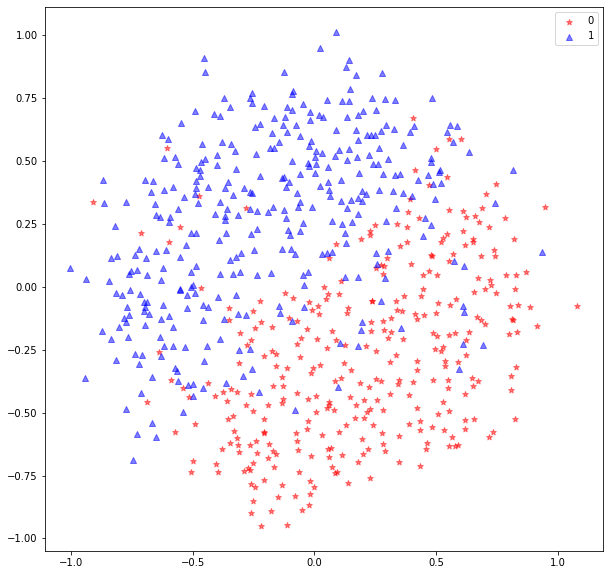

In [18]:
name = 'euclidean'
train_orig_dis = dissim_matrix(train_X_fried_tensor, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, train_labels)

#### visualize test

In [19]:
test_embs,test_labels = extract_embeddings(test_X_fried_tensor , test_label_fried, model)

In [20]:
name = 'euclidean'
test_dis = dissim_matrix(test_embs, name)

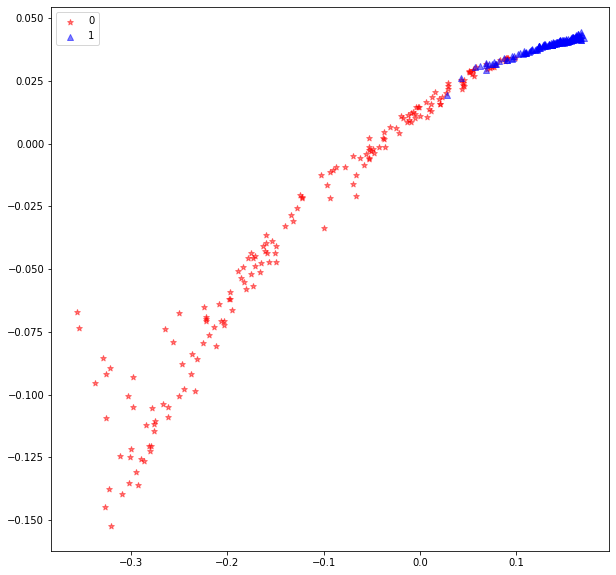

In [21]:
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, test_labels)

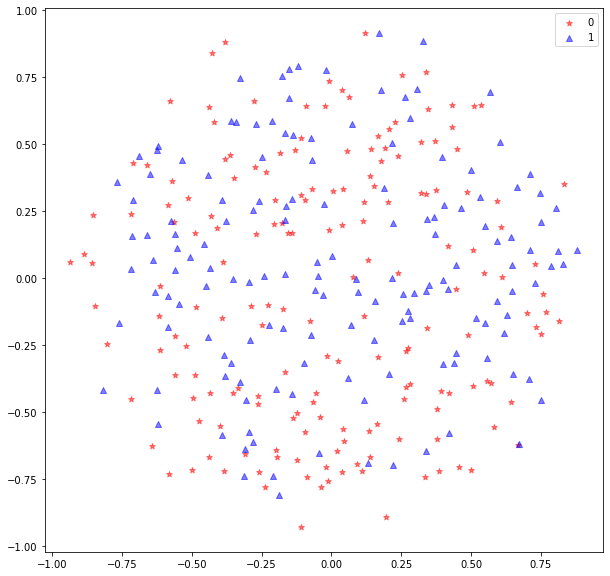

In [22]:
name = 'euclidean'
test_orig_dis = dissim_matrix(test_X_fried_tensor, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig, test_labels)

## Diffusion - chemical grouping

In [23]:
diffusion = pd.read_csv('./data/Diffusion_data.csv')
diffusion_shuffled = diffusion.sample(frac=1).reset_index(drop=True)
labels = []
for name in diffusion_shuffled ['group']:
    if name == 'transition_metal':
        labels.append(1)
    else:
        labels.append(0)

drop_columns = ['E_regression', 'E_regression_shift', 'group',
               'Material compositions 2', 'Material compositions 1']
diffusion_shuffled  = diffusion_shuffled .drop(drop_columns, axis = 1)

In [24]:
train_X_diffu, test_X_diffu,train_label_diffu, test_label_diffu = train_test_split(
    diffusion_shuffled, labels, test_size=0.33, random_state=42)

train_X_diffu_tensor = torch.tensor(train_X_diffu.values )
test_X_diffu_tensor = torch.tensor(test_X_diffu.values )

In [27]:
distance = None
margin = 2
loss_fn = HardEasyNegativesBatchLoss( margin = margin, distance = distance)
# loss_fn = loss_fn2
lr = 1e-3

hidden_size = 100
embedding_size = 20
input_size = train_X_diffu_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20

datasampler = BatchPairSampling( dataset = train_X_diffu_tensor, labels= train_label_diffu)
batch_size = 8 
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 10

In [28]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/273 (0%)]	Loss: 1.448257
Train: [80/273 (29%)]	Loss: 1.676484
Train: [160/273 (57%)]	Loss: 1.834132
Train: [240/273 (86%)]	Loss: 1.586469
Epoch: 1/20. Train set: Average loss: 1.7204
Train: [0/273 (0%)]	Loss: 1.951797
Train: [80/273 (29%)]	Loss: 1.867855
Train: [160/273 (57%)]	Loss: 1.338227
Train: [240/273 (86%)]	Loss: 1.955971
Epoch: 2/20. Train set: Average loss: 1.7596
Train: [0/273 (0%)]	Loss: 1.551728
Train: [80/273 (29%)]	Loss: 1.824495
Train: [160/273 (57%)]	Loss: 1.609859
Train: [240/273 (86%)]	Loss: 1.633205
Epoch: 3/20. Train set: Average loss: 1.6659
Train: [0/273 (0%)]	Loss: 1.997764
Train: [80/273 (29%)]	Loss: 1.422027
Train: [160/273 (57%)]	Loss: 1.595413
Train: [240/273 (86%)]	Loss: 1.609229
Epoch: 4/20. Train set: Average loss: 1.6048
Train: [0/273 (0%)]	Loss: 1.999711
Train: [80/273 (29%)]	Loss: 1.783381
Train: [160/273 (57%)]	Loss: 1.449098
Train: [240/273 (86%)]	Loss: 1.609483
Epoch: 5/20. Train set: Average loss: 1.6689
Train: [0/273 (0%)]	Loss: 1.999922


#### Visualize train

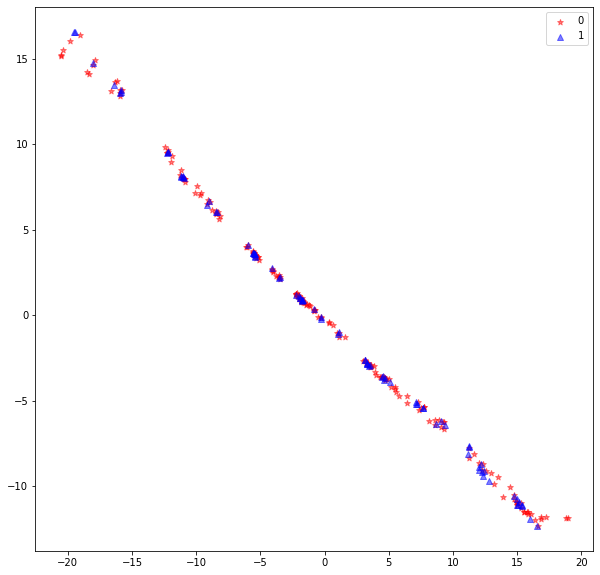

In [29]:
train_embs,train_labels = extract_embeddings(train_X_diffu_tensor , train_label_diffu, model)
name = 'euclidean'
train_dis = dissim_matrix(train_embs, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, train_labels)

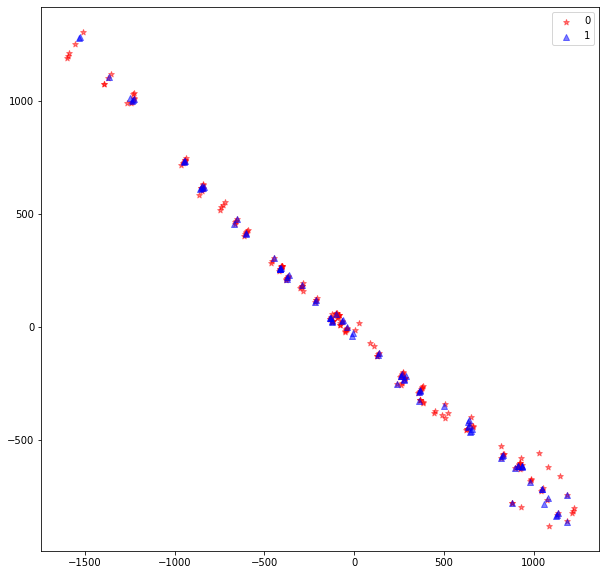

In [31]:
name = 'euclidean'
train_orig_dis = dissim_matrix(train_X_diffu_tensor, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, train_labels)

#### Visualize test

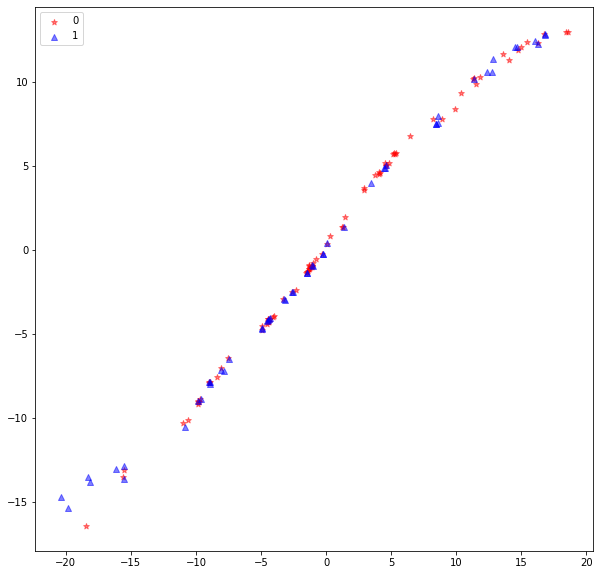

In [34]:
test_embs,test_labels = extract_embeddings(test_X_diffu_tensor , test_label_diffu, model)
name = 'euclidean'
test_dis = dissim_matrix(test_embs, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, test_labels)

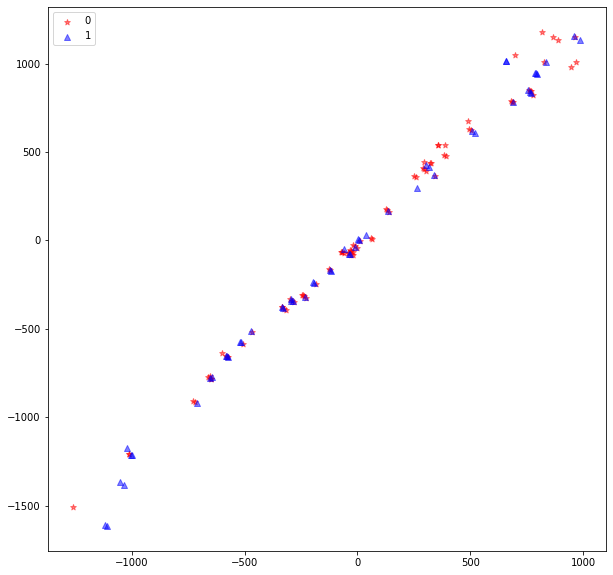

In [36]:
name = 'euclidean'
test_orig_dis = dissim_matrix(test_X_diffu_tensor, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig, test_labels)

### Supercond - chemical grouping

In [38]:

supercond = pd.read_excel('./data/Supercon_data_features_selected.xlsx')
supercond_shuffled = supercond.sample(frac=1).reset_index(drop=True)

labels = []
for name in supercond['group']:
    if name == 'cuprates':
        labels.append(1)
    else:
        labels.append(0)
supercond['group'] = labels


drop_columns = [
                 'name',
                 'group',
                 'Tc', 'ln(Tc)'
                 ]
supercond_shuffled  = supercond_shuffled .drop(drop_columns, axis = 1)

In [42]:
train_X_supercond, test_X_supercond,train_label_supercond, test_label_supercond = train_test_split(
    supercond_shuffled, labels, test_size=0.33, random_state=42)

train_X_supercond_tensor = torch.tensor(train_X_supercond.values )
test_X_supercond_tensor = torch.tensor(test_X_supercond.values )

In [58]:
distance = None
margin = 2
loss_fn = HardEasyNegativesBatchLoss( margin = margin, distance = distance)
# loss_fn = loss_fn2
lr = 1e-4

hidden_size = 100
embedding_size = 20
input_size = train_X_supercond_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50

datasampler = BatchPairSampling( dataset = train_X_supercond_tensor, labels= train_label_supercond)
batch_size = 25
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 200

In [59]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/4188 (0%)]	Loss: 1.938151
Epoch: 1/50. Train set: Average loss: 1.6055
Train: [0/4188 (0%)]	Loss: 2.058211
Epoch: 2/50. Train set: Average loss: 1.4969
Train: [0/4188 (0%)]	Loss: 2.000052
Epoch: 3/50. Train set: Average loss: 1.5009
Train: [0/4188 (0%)]	Loss: 0.100723
Epoch: 4/50. Train set: Average loss: 1.4009
Train: [0/4188 (0%)]	Loss: 0.102851
Epoch: 5/50. Train set: Average loss: 1.5106
Train: [0/4188 (0%)]	Loss: 1.992203
Epoch: 6/50. Train set: Average loss: 1.4130
Train: [0/4188 (0%)]	Loss: 1.998891
Epoch: 7/50. Train set: Average loss: 1.4107
Train: [0/4188 (0%)]	Loss: 0.040150
Epoch: 8/50. Train set: Average loss: 1.4351
Train: [0/4188 (0%)]	Loss: 0.054398
Epoch: 9/50. Train set: Average loss: 1.4235
Train: [0/4188 (0%)]	Loss: 1.990144
Epoch: 10/50. Train set: Average loss: 1.4268
Train: [0/4188 (0%)]	Loss: 1.997176
Epoch: 11/50. Train set: Average loss: 1.3852
Train: [0/4188 (0%)]	Loss: 1.994848
Epoch: 12/50. Train set: Average loss: 1.5083
Train: [0/4188 (0%)]	Loss

#### Visualize train

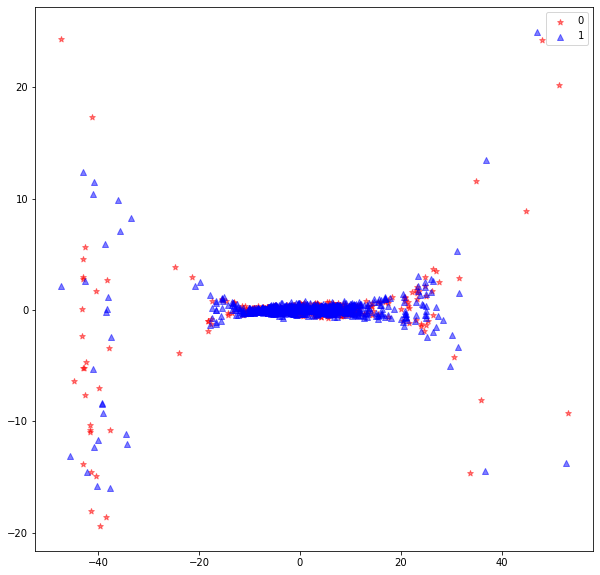

In [60]:
train_embs,train_labels = extract_embeddings(train_X_supercond_tensor , train_label_supercond, model)


# sample some of them for plotting
embs_resample_train, labels_resample_train = smaples_for_plotting(0.5, train_label_supercond, train_embs)

name = 'euclidean'
train_dis = dissim_matrix(embs_resample_train, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, labels_resample_train)

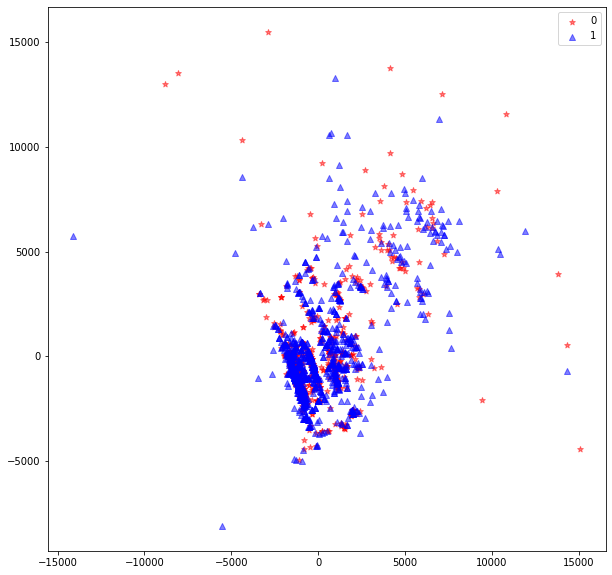

In [68]:

orig_data_train, labels_resample_orig_train = smaples_for_plotting(0.5, train_label_supercond,train_X_supercond_tensor)

name = 'euclidean'
train_orig_dis = dissim_matrix(orig_data_train, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, labels_resample_orig_train)

#### visual test

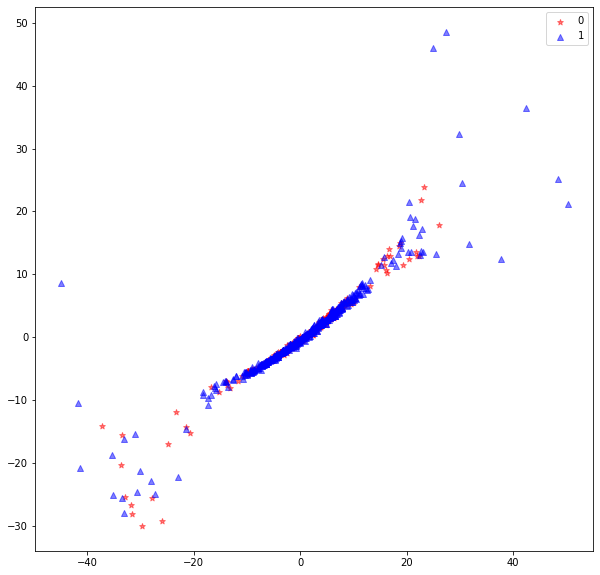

In [67]:
test_embs,test_labels = extract_embeddings(test_X_supercond_tensor , test_label_supercond, model)


# sample some of them for plotting
embs_resample_test, labels_resample_test = smaples_for_plotting(0.5, test_label_supercond, test_embs)

name = 'euclidean'
test_dis = dissim_matrix(embs_resample_test, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, labels_resample_test)

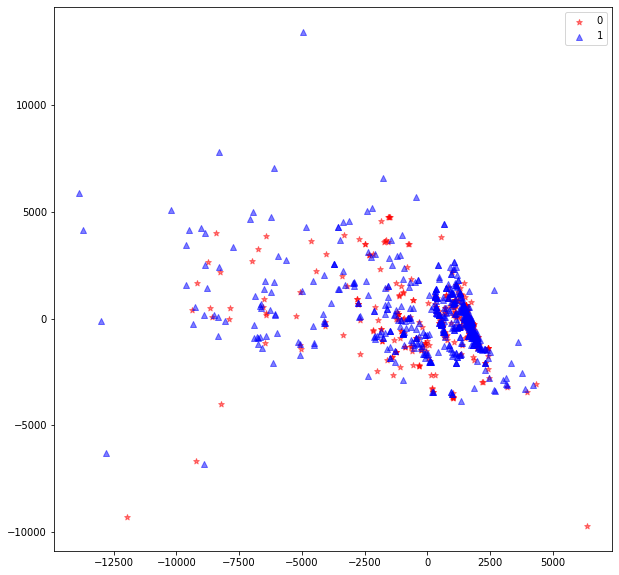

In [69]:
orig_data_test, labels_resample_orig_test = smaples_for_plotting(0.5, test_label_supercond,test_X_supercond_tensor)

name = 'euclidean'
test_orig_dis = dissim_matrix(orig_data_test, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig , labels_resample_orig_test)

### Diffusion - gs mixture

In [71]:
diffusion = pd.read_csv('./data/Diffusion_data.csv')
diffusion_shuffled = diffusion.sample(frac=1).reset_index(drop=True)
drop_columns = ['E_regression', 'E_regression_shift', 'group',
               'Material compositions 2', 'Material compositions 1']
diffusion_shuffled  = diffusion_shuffled .drop(drop_columns, axis = 1)
labels = GaussianMixture(n_components=2, random_state=0).fit_predict(diffusion_shuffled)


In [72]:
train_X_diffu, test_X_diffu,train_label_diffu, test_label_diffu = train_test_split(
    diffusion_shuffled, labels, test_size=0.33, random_state=42)

train_X_diffu_tensor = torch.tensor(train_X_diffu.values )
test_X_diffu_tensor = torch.tensor(test_X_diffu.values )

In [73]:
distance = None
margin = 2
loss_fn = HardEasyNegativesBatchLoss( margin = margin, distance = distance)
# loss_fn = loss_fn2
lr = 1e-3

hidden_size = 100
embedding_size = 20
input_size = train_X_diffu_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20

datasampler = BatchPairSampling( dataset = train_X_diffu_tensor, labels= train_label_diffu)
batch_size = 8 
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 10

In [74]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/273 (0%)]	Loss: 1.933619
Train: [80/273 (29%)]	Loss: 1.730372
Train: [160/273 (57%)]	Loss: 1.278651
Train: [240/273 (86%)]	Loss: 0.520568
Epoch: 1/20. Train set: Average loss: 1.2280
Train: [0/273 (0%)]	Loss: 1.947870
Train: [80/273 (29%)]	Loss: 1.917037
Train: [160/273 (57%)]	Loss: 1.751454
Train: [240/273 (86%)]	Loss: 1.016904
Epoch: 2/20. Train set: Average loss: 1.6214
Train: [0/273 (0%)]	Loss: 1.942353
Train: [80/273 (29%)]	Loss: 1.914584
Train: [160/273 (57%)]	Loss: 1.827169
Train: [240/273 (86%)]	Loss: 1.326203
Epoch: 3/20. Train set: Average loss: 1.7304
Train: [0/273 (0%)]	Loss: 1.981739
Train: [80/273 (29%)]	Loss: 1.952709
Train: [160/273 (57%)]	Loss: 1.863721
Train: [240/273 (86%)]	Loss: 1.498917
Epoch: 4/20. Train set: Average loss: 1.6687
Train: [0/273 (0%)]	Loss: 0.441220
Train: [80/273 (29%)]	Loss: 1.423435
Train: [160/273 (57%)]	Loss: 0.324601
Train: [240/273 (86%)]	Loss: 0.235667
Epoch: 5/20. Train set: Average loss: 0.6967
Train: [0/273 (0%)]	Loss: 1.998746


In [75]:
#### Visualize train

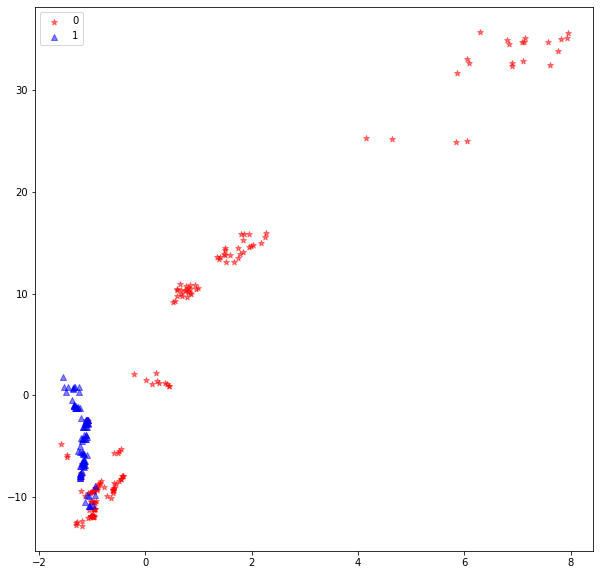

In [80]:
train_embs,train_labels = extract_embeddings(train_X_diffu_tensor , train_label_diffu, model)
name = 'euclidean'
train_dis = dissim_matrix(train_embs, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, train_labels)

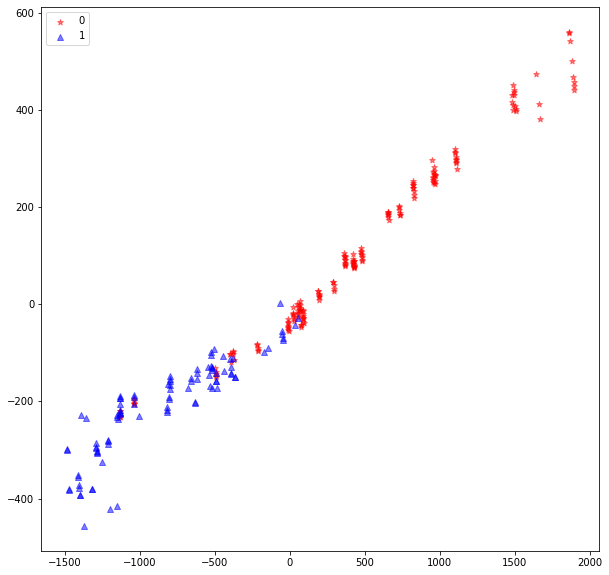

In [81]:
name = 'euclidean'
train_orig_dis = dissim_matrix(train_X_diffu_tensor, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, train_labels)

#### Visualize test

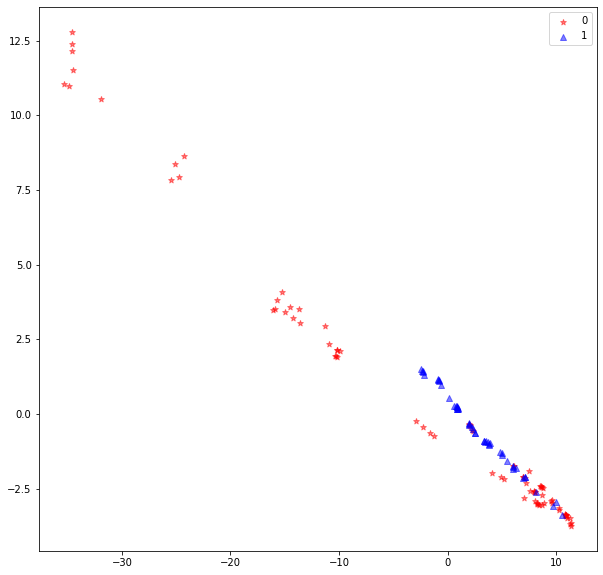

In [83]:
test_embs,test_labels = extract_embeddings(test_X_diffu_tensor , test_label_diffu, model)
name = 'euclidean'
test_dis = dissim_matrix(test_embs, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, test_labels)

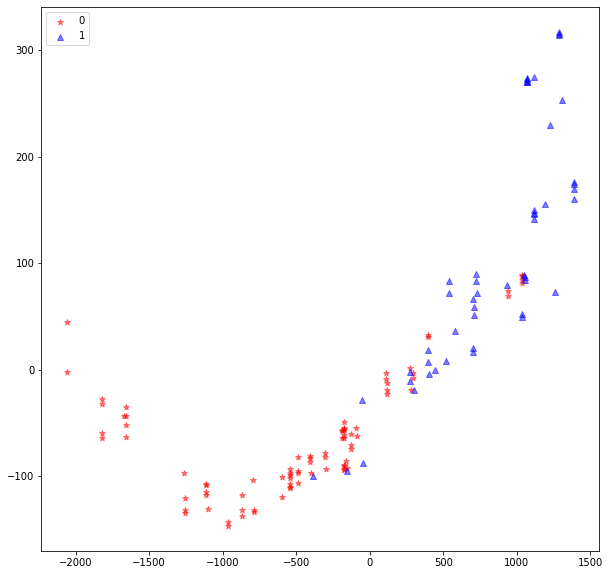

In [84]:
name = 'euclidean'
test_orig_dis = dissim_matrix(test_X_diffu_tensor, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig, test_labels)

### Supercond - GS mixture

In [86]:
supercond = pd.read_excel('./data/Supercon_data_features_selected.xlsx')
supercond_shuffled = supercond.sample(frac=1).reset_index(drop=True)

drop_columns = [
                 'name',
                 'group',
                 'Tc', 'ln(Tc)'
                 ]
supercond_shuffled  = supercond_shuffled .drop(drop_columns, axis = 1)

labels = GaussianMixture(n_components=2, random_state=0).fit_predict(supercond_shuffled )

In [87]:
train_X_supercond, test_X_supercond,train_label_supercond, test_label_supercond = train_test_split(
    supercond_shuffled, labels, test_size=0.33, random_state=42)

train_X_supercond_tensor = torch.tensor(train_X_supercond.values )
test_X_supercond_tensor = torch.tensor(test_X_supercond.values )

In [88]:
distance = None
margin = 2
loss_fn = HardEasyNegativesBatchLoss( margin = margin, distance = distance)
# loss_fn = loss_fn2
lr = 1e-4

hidden_size = 100
embedding_size = 20
input_size = train_X_supercond_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50

datasampler = BatchPairSampling( dataset = train_X_supercond_tensor, labels= train_label_supercond)
batch_size = 25
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 200

In [89]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/4188 (0%)]	Loss: 1.993315
Epoch: 1/50. Train set: Average loss: 1.3609
Train: [0/4188 (0%)]	Loss: 1.993414
Epoch: 2/50. Train set: Average loss: 1.1821
Train: [0/4188 (0%)]	Loss: 0.404430
Epoch: 3/50. Train set: Average loss: 1.2930
Train: [0/4188 (0%)]	Loss: 0.123497
Epoch: 4/50. Train set: Average loss: 1.3056
Train: [0/4188 (0%)]	Loss: 2.044792
Epoch: 5/50. Train set: Average loss: 1.1942
Train: [0/4188 (0%)]	Loss: 0.063729
Epoch: 6/50. Train set: Average loss: 1.2716
Train: [0/4188 (0%)]	Loss: 1.970265
Epoch: 7/50. Train set: Average loss: 1.1340
Train: [0/4188 (0%)]	Loss: 0.555717
Epoch: 8/50. Train set: Average loss: 1.0301
Train: [0/4188 (0%)]	Loss: 0.923552
Epoch: 9/50. Train set: Average loss: 0.9652
Train: [0/4188 (0%)]	Loss: 2.000211
Epoch: 10/50. Train set: Average loss: 0.8211
Train: [0/4188 (0%)]	Loss: 1.908002
Epoch: 11/50. Train set: Average loss: 0.6987
Train: [0/4188 (0%)]	Loss: 0.043681
Epoch: 12/50. Train set: Average loss: 0.6559
Train: [0/4188 (0%)]	Loss

#### Visualize train

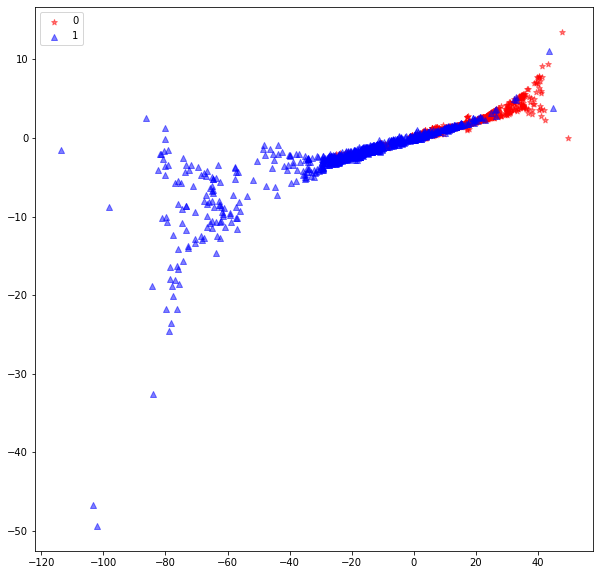

In [90]:
train_embs,train_labels = extract_embeddings(train_X_supercond_tensor , train_label_supercond, model)


# sample some of them for plotting
embs_resample_train, labels_resample_train = smaples_for_plotting(0.5, train_label_supercond, train_embs)

name = 'euclidean'
train_dis = dissim_matrix(embs_resample_train, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, labels_resample_train)

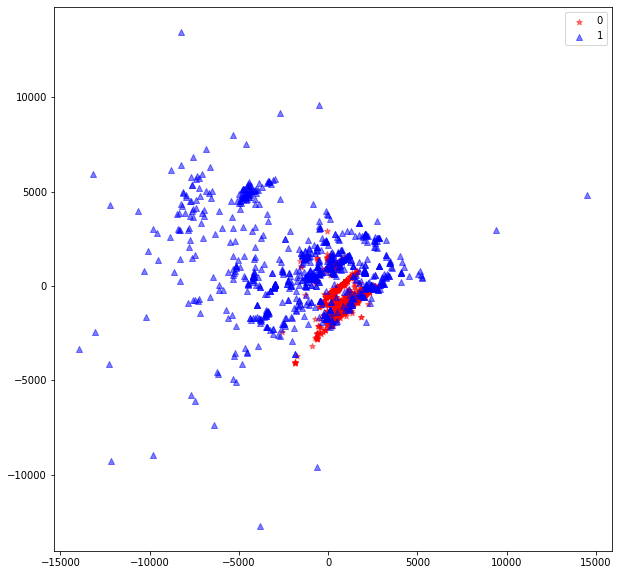

In [91]:
orig_data_train, labels_resample_orig_train = smaples_for_plotting(0.5, train_label_supercond,train_X_supercond_tensor)

name = 'euclidean'
train_orig_dis = dissim_matrix(orig_data_train, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, labels_resample_orig_train)

#### Visualize test

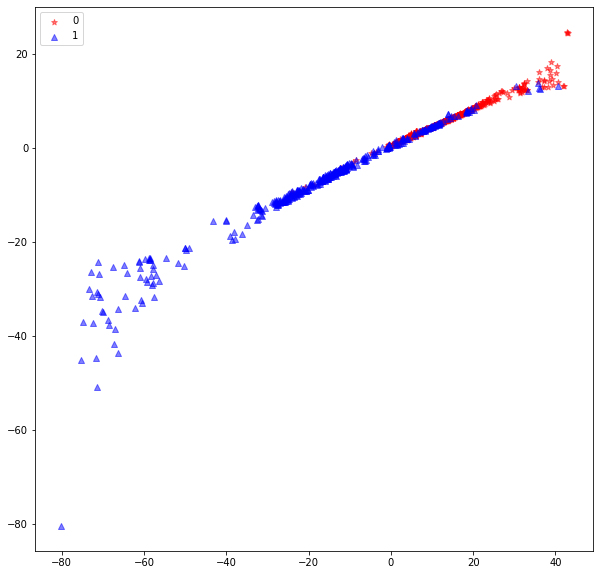

In [93]:
test_embs,test_labels = extract_embeddings(test_X_supercond_tensor , test_label_supercond, model)


# sample some of them for plotting
embs_resample_test, labels_resample_test = smaples_for_plotting(0.5, test_label_supercond, test_embs)

name = 'euclidean'
test_dis = dissim_matrix(embs_resample_test, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, labels_resample_test)

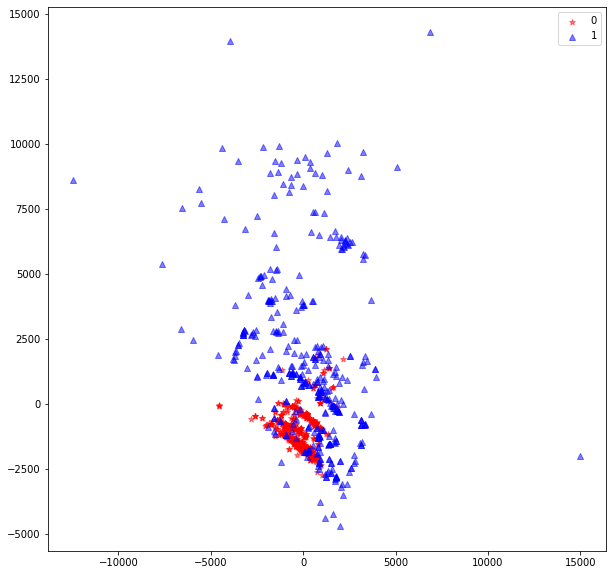

In [94]:
orig_data_test, labels_resample_orig_test = smaples_for_plotting(0.5, test_label_supercond,test_X_supercond_tensor)

name = 'euclidean'
test_orig_dis = dissim_matrix(orig_data_test, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig , labels_resample_orig_test)